# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
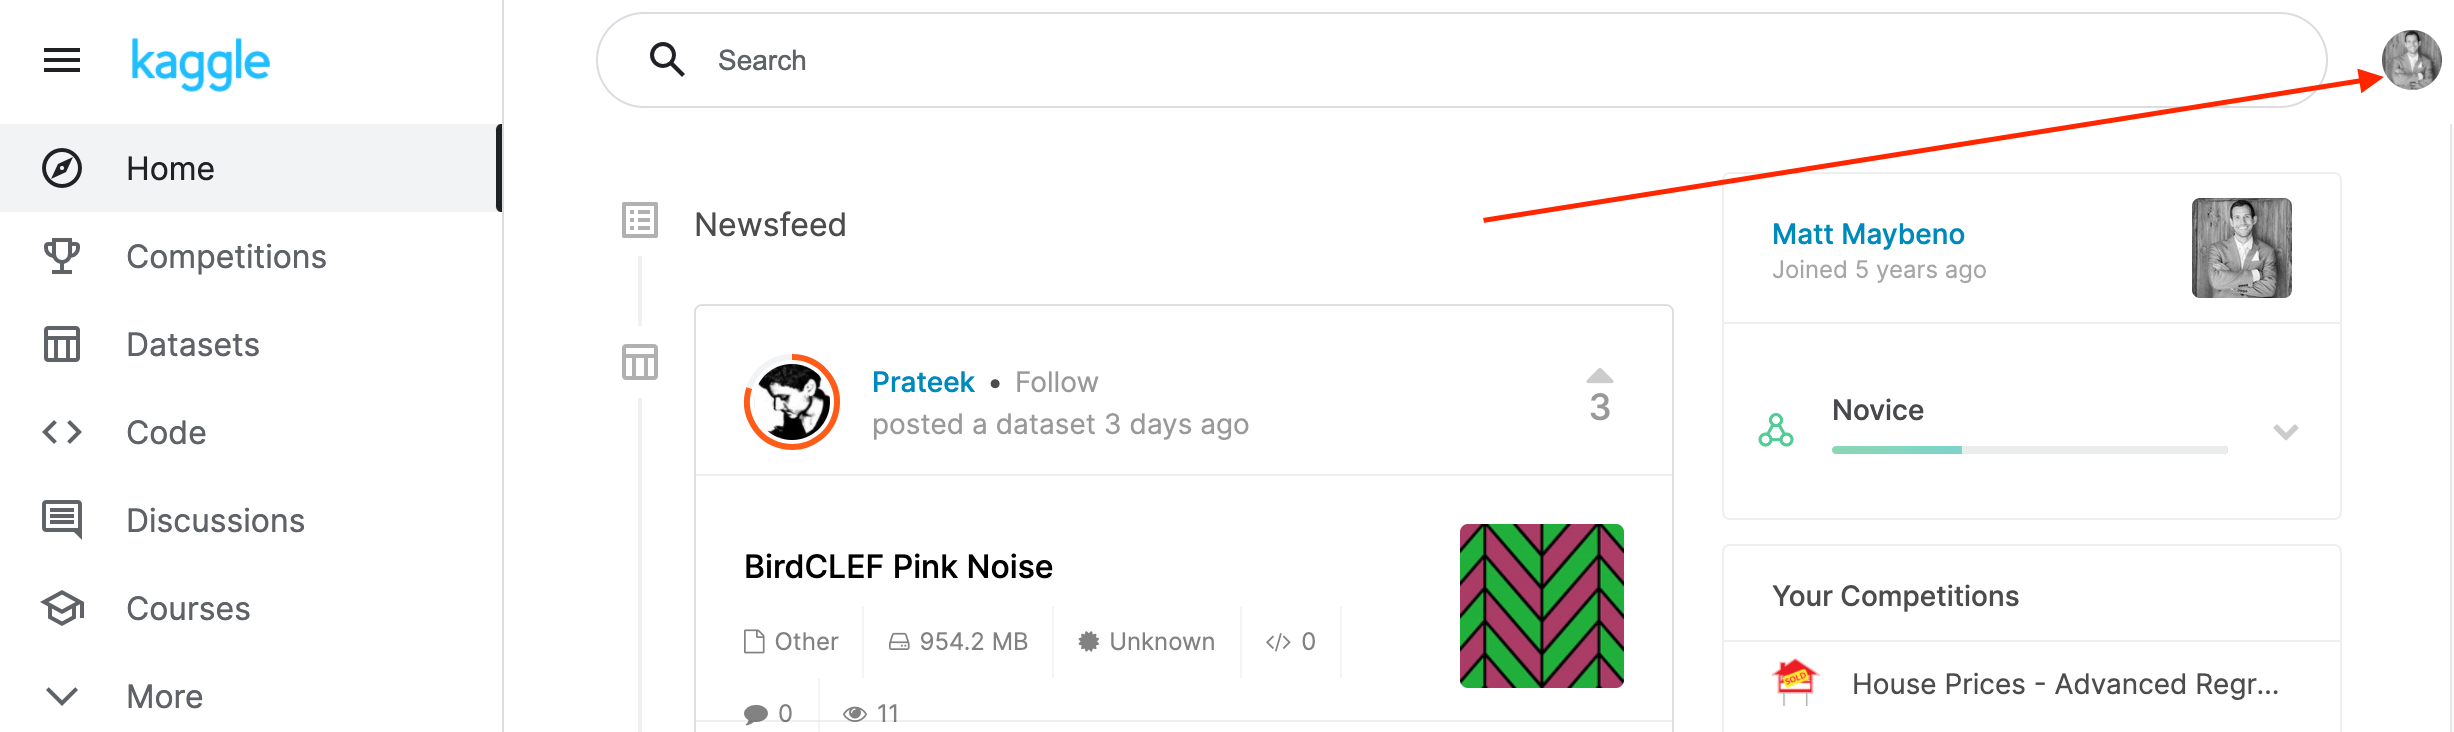
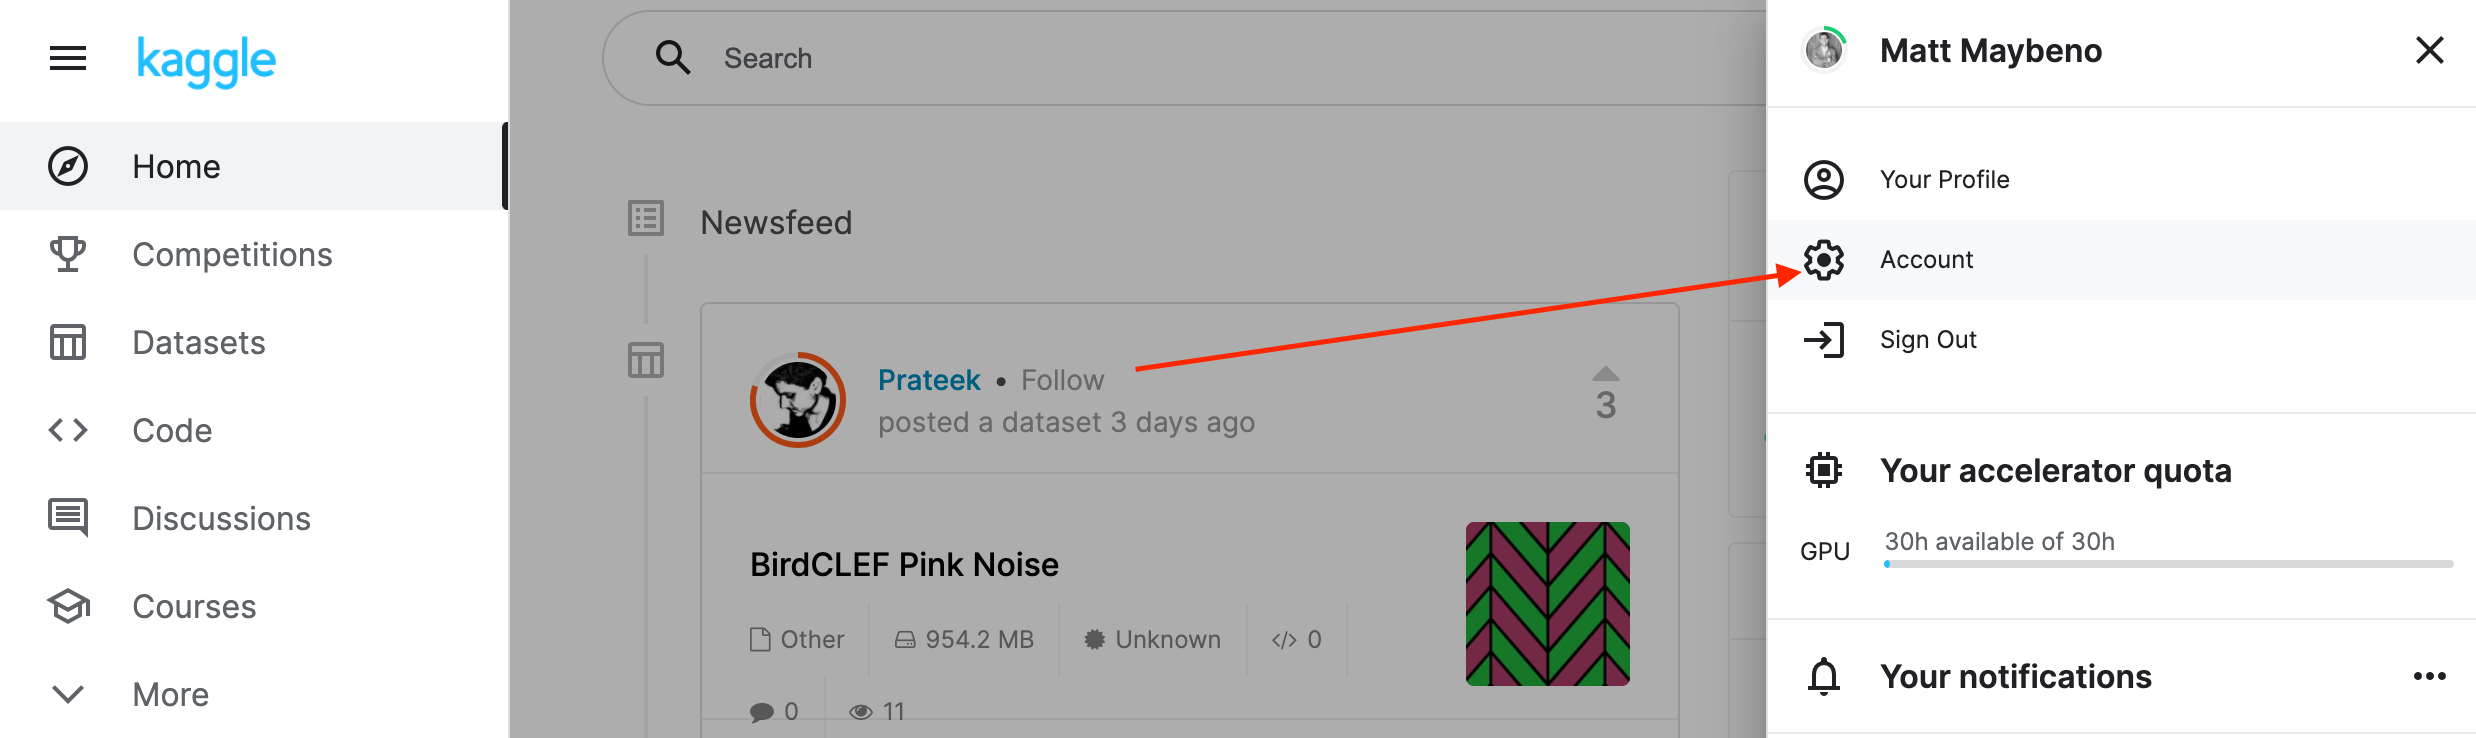
2. Scroll down to API and click Create New API Token.
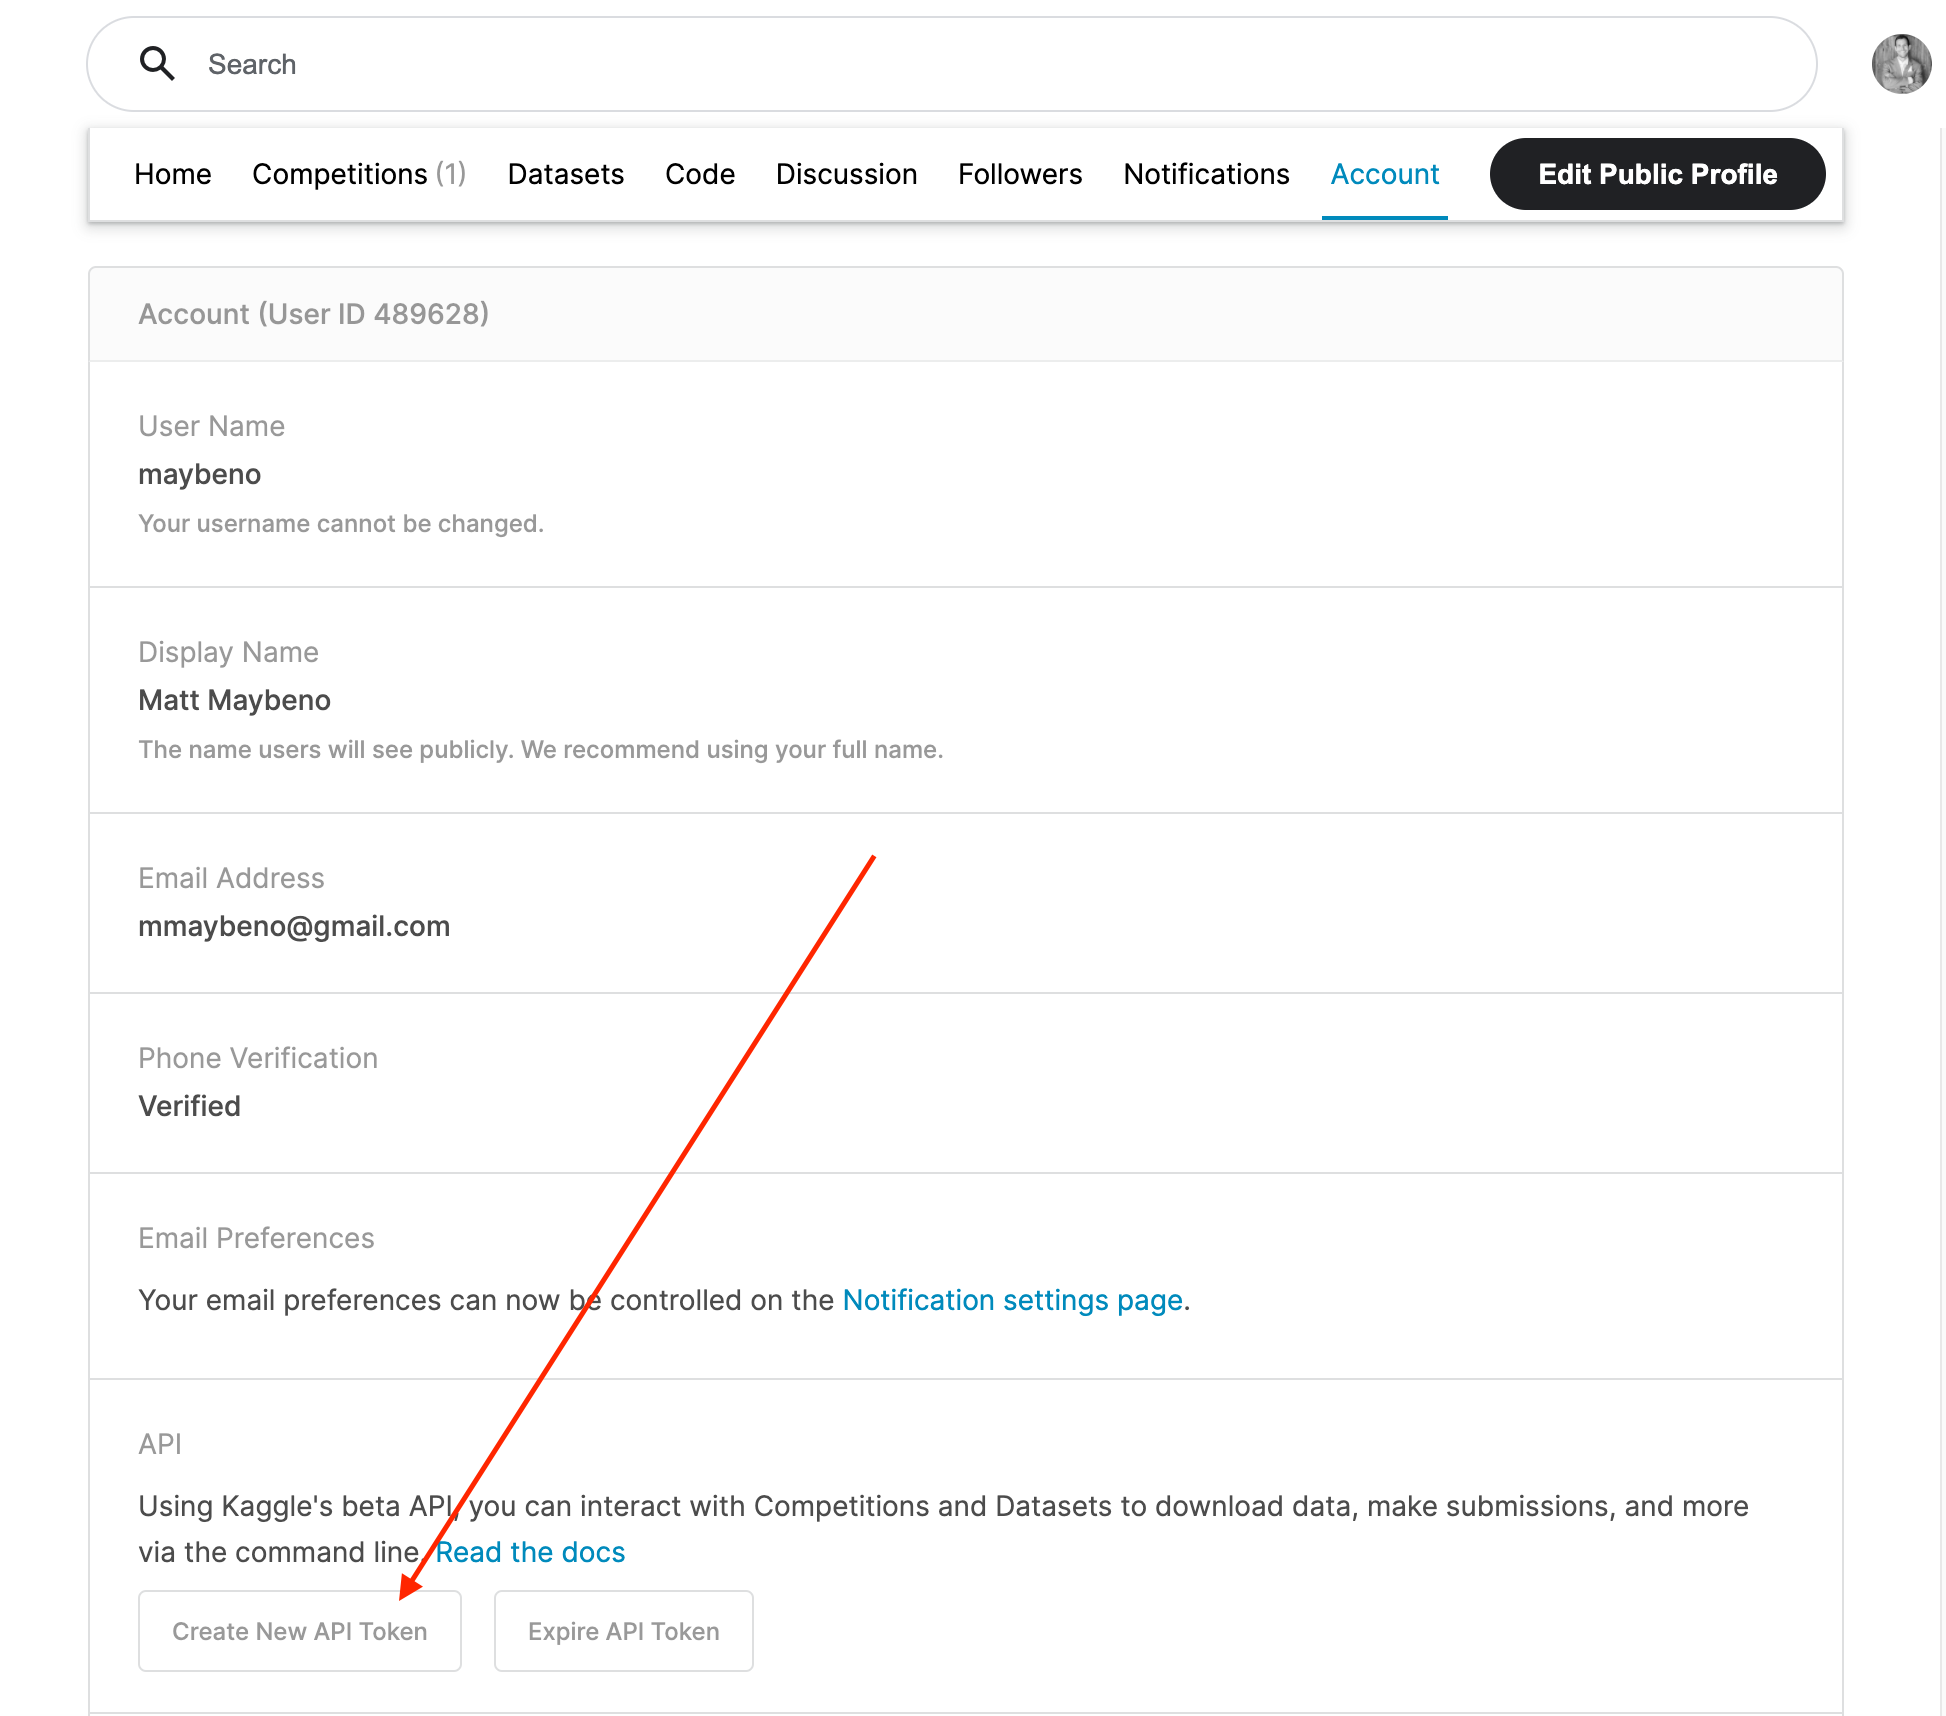
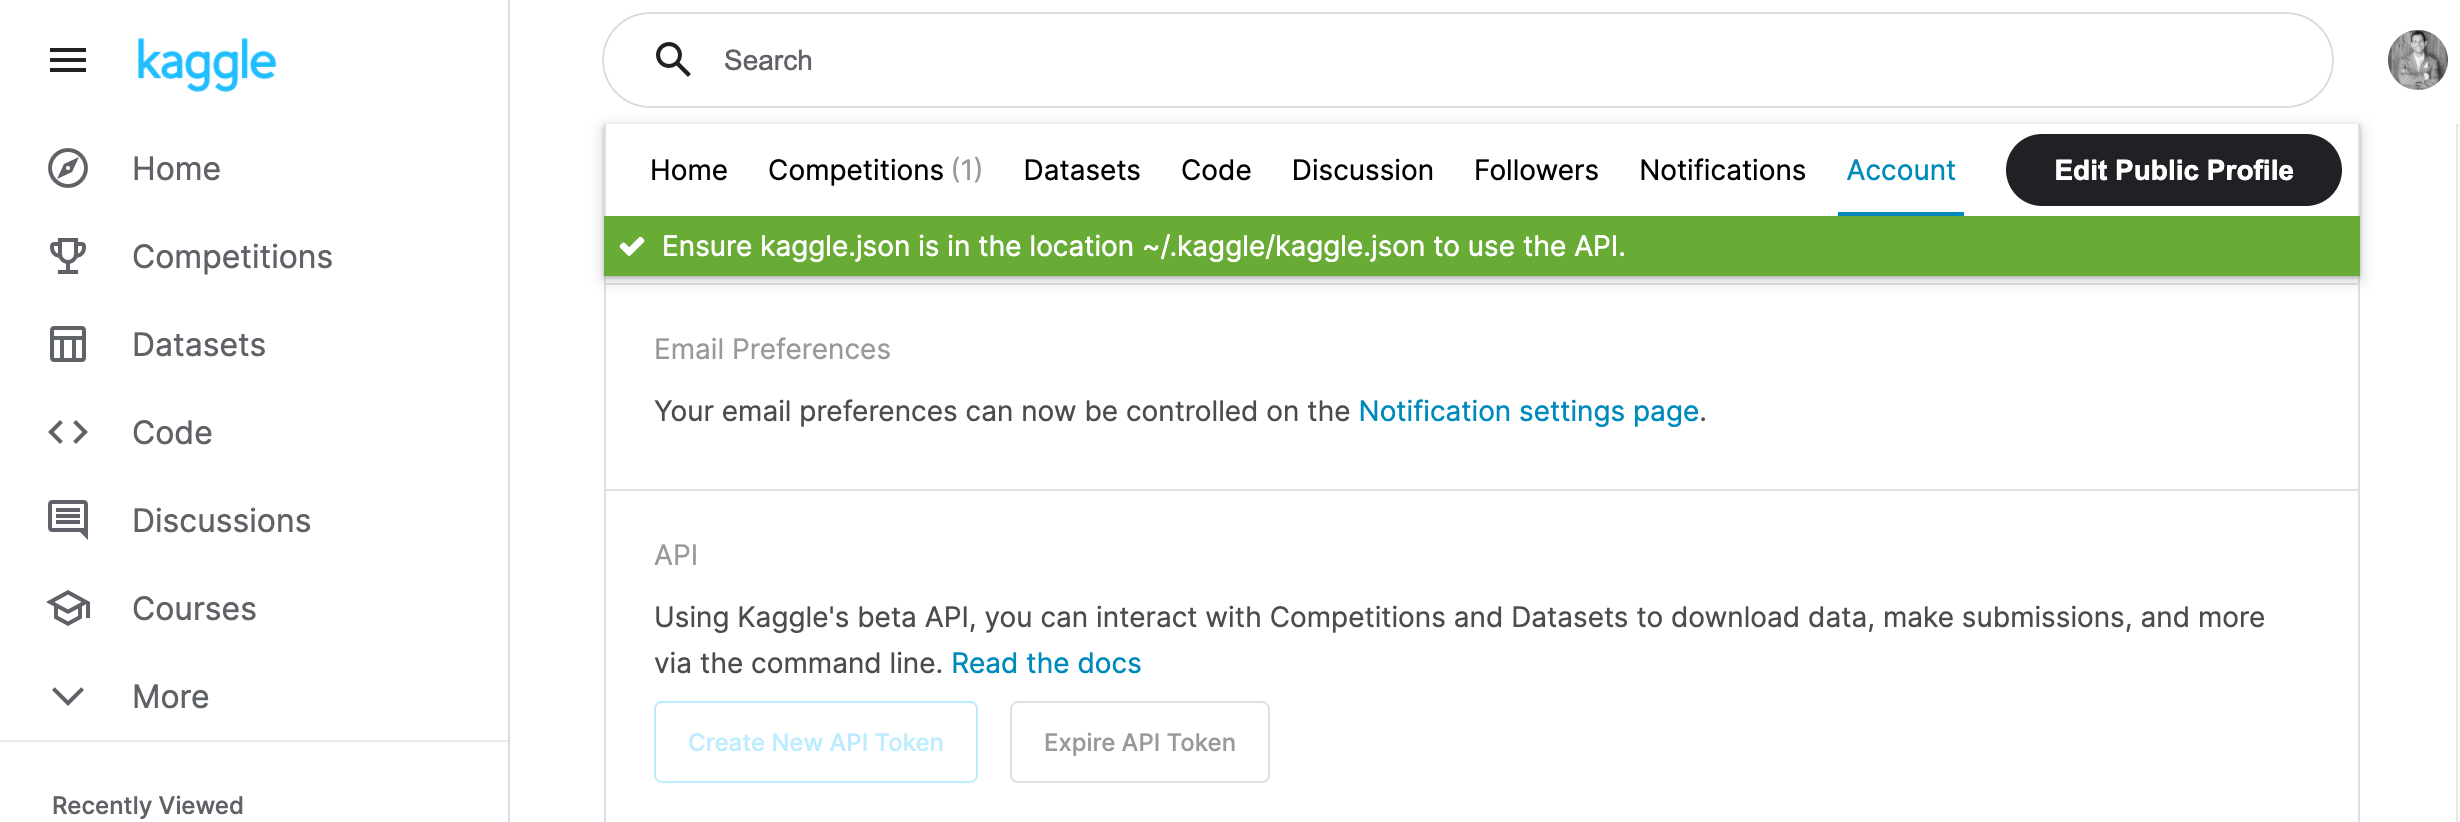
3. Open up `kaggle.json` and use the username and key.
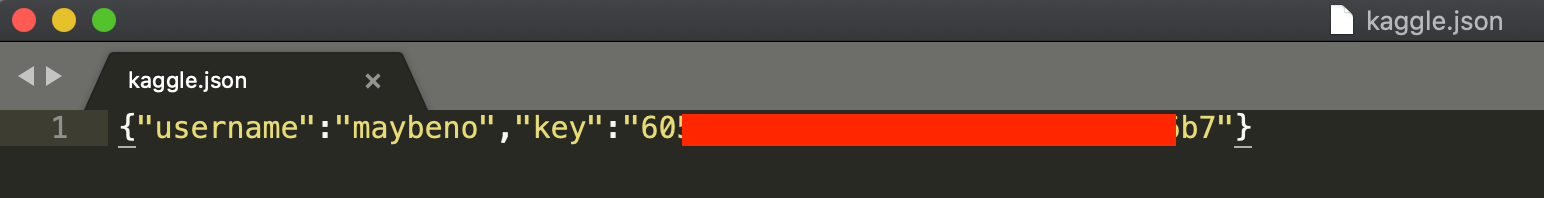

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
%cd

/root


In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "yasmineelegily"
kaggle_key = "085b60c9355b9cf69079b9e3bf91bde2"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
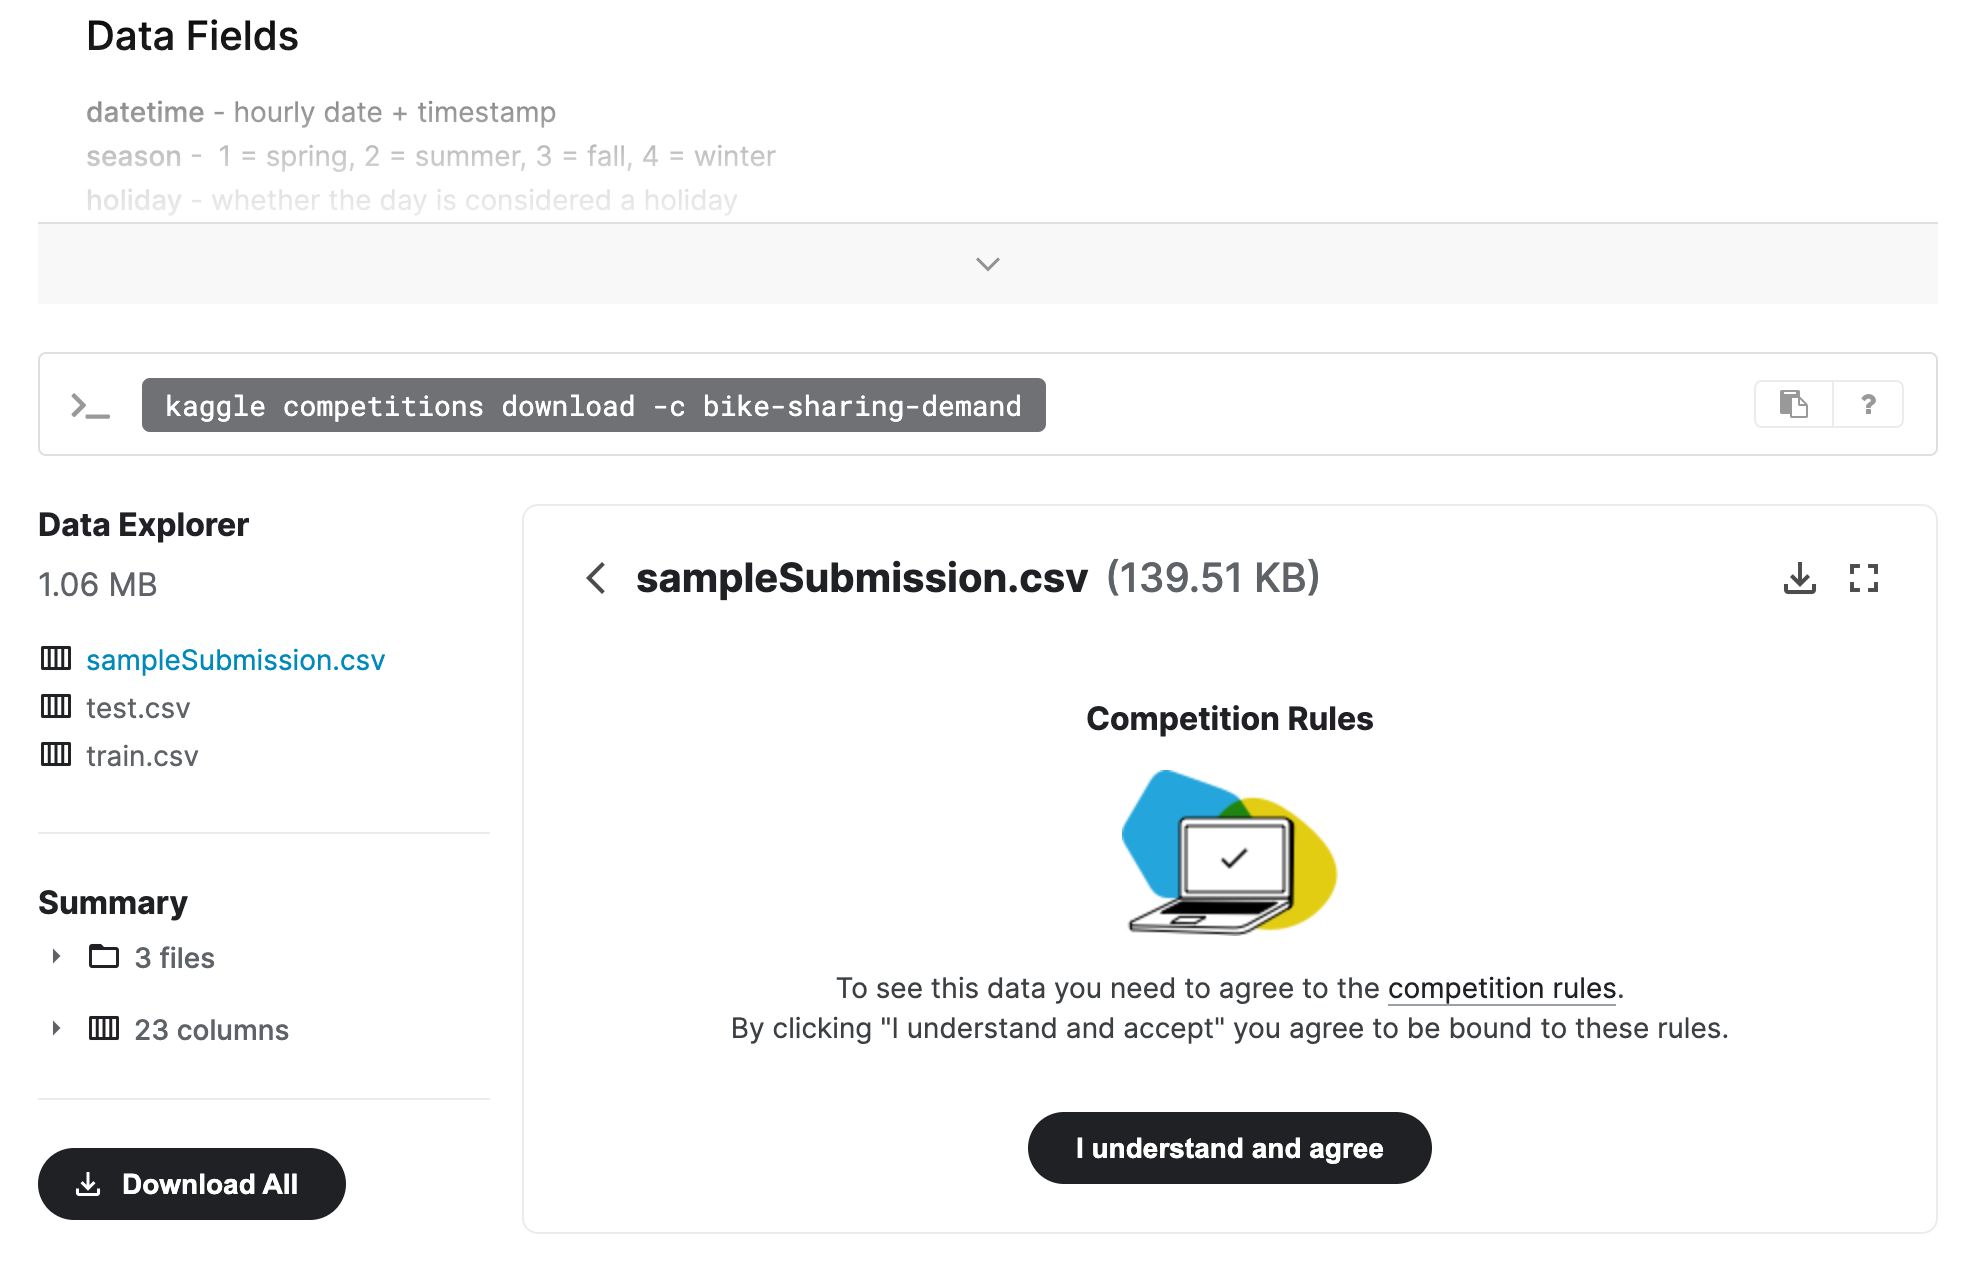

In [5]:
!pip install kaggle

In [6]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
from autogluon.tabular import TabularPredictor
#from .autonotebook 
import tqdm as notebook_tqdm

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
import pandas as pd
train = pd.read_csv('train.csv', parse_dates = ['datetime'])
#%timeit pd.to_datetime(train['datetime'], infer_datetime_format=True)
#train['datetime']=pd.to_datetime(train['datetime'], infer_datetime_format=True)

train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [9]:
train.describe()
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

In [10]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv',parse_dates = ['datetime'])
#%timeit pd.to_datetime(test['datetime'], infer_datetime_format=True)
#test['datetime']=pd.to_datetime(test['datetime'], infer_datetime_format=True)
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [11]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00      0

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [12]:
train.columns
df_train = train[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count']]
df_train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  count  
0        81        0.0     16  
1        80        0.0     40  
2        80        0.0     32  
3        75        0.0     13  
4        75        0.0      1

In [13]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor

In [14]:
predictor = TabularPredictor(label = 'count', problem_type = 'regression', eval_metric = 'root_mean_squared_error').fit(train_data=df_train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221216_173248/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221216_173248/"
AutoGluon Version:  0.6.1
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2947.37 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

### Review AutoGluon's training run with ranking of models that did the best.

In [15]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.096195      16.543457  553.404318                0.001313           0.315243            3       True         14
1   RandomForestMSE_BAG_L2  -53.394231      10.642624  410.895678                0.619374          26.408351            2       True         12
2          LightGBM_BAG_L2  -55.160769      10.262149  409.682666                0.238899          25.195338            2       True         11
3          CatBoost_BAG_L2  -55.701867      10.116271  445.974267                0.093021          61.486940            2       True         13
4        LightGBMXT_BAG_L2  -60.277560      15.590850  439.998446                5.567600          55.511118            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.103733    0.029298         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54

### Create predictions from test dataset

In [16]:
predictions = predictor.predict(test)
predictions.head()

0    23.582502
1    42.590725
2    46.027683
3    49.433861
4    51.866123
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [17]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.934547
std        89.966553
min         3.142566
25%        20.124580
50%        64.189423
75%       167.691757
max       364.549774
Name: count, dtype: float64

In [18]:
# How many negative values do we have?
#?

In [19]:
# Set them to zero
#?

### Set predictions to submission dataframe, save, and submit

In [20]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [21]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 320kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2022-12-16 17:43:33  first raw submission               complete  1.79476      1.79476       
submission_new_hpo.csv       2022-12-16 16:21:20  new features with hyperparameters  error                                
submission_new_features.csv  2022-12-16 16:18:46  new features                       complete  1.78581      1.78581       
submission.csv               2022-12-16 16:08:05  first raw submission               complete  1.79465      1.79465       


#### Initial score of `1.79476

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

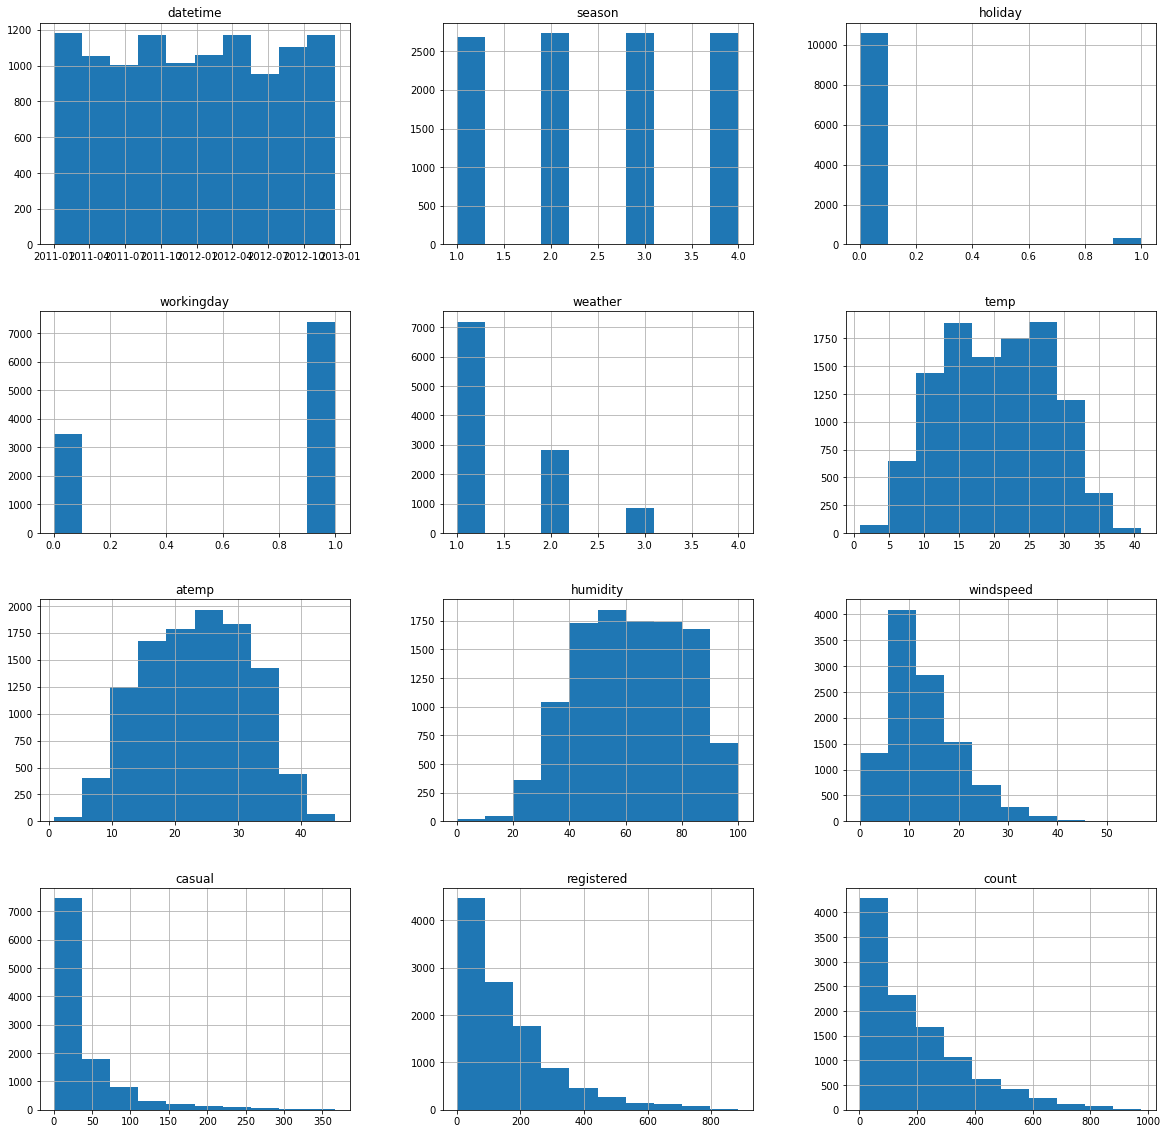

In [24]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(20,20))

In [25]:
# create a new feature
train['date_year'] = train['datetime'].dt.year
train['date_month'] = train['datetime'].dt.month
train['date_day'] = train['datetime'].dt.day

test['date_year'] = test['datetime'].dt.year
test['date_month'] = test['datetime'].dt.month
test['date_day'] = test['datetime'].dt.day
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  date_year  date_month  \
0        81        0.0       3          13     16       2011           1   
1        80        0.0       8          32     40       2011           1   
2        80        0.0       5          27     32       2011           1   
3        75        0.0       3          10     13       2011           1   
4        75        0.0       0           1      1       2011           1   

   date_day  
0         1  
1         1  
2         1  
3         1  
4         1

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [26]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [27]:
# View are new feature
train.head()

datetime season  holiday  workingday weather  temp   atemp  \
0 2011-01-01 00:00:00      1        0           0       1  9.84  14.395   
1 2011-01-01 01:00:00      1        0           0       1  9.02  13.635   
2 2011-01-01 02:00:00      1        0           0       1  9.02  13.635   
3 2011-01-01 03:00:00      1        0           0       1  9.84  14.395   
4 2011-01-01 04:00:00      1        0           0       1  9.84  14.395   

   humidity  windspeed  casual  registered  count  date_year  date_month  \
0        81        0.0       3          13     16       2011           1   
1        80        0.0       8          32     40       2011           1   
2        80        0.0       5          27     32       2011           1   
3        75        0.0       3          10     13       2011           1   
4        75        0.0       0           1      1       2011           1   

   date_day  
0         1  
1         1  
2         1  
3         1  
4         1

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>],
       [<AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'date_year'}>,
        <AxesSubplot:title={'center':'date_month'}>],
       [<AxesSubplot:title={'center':'date_day'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

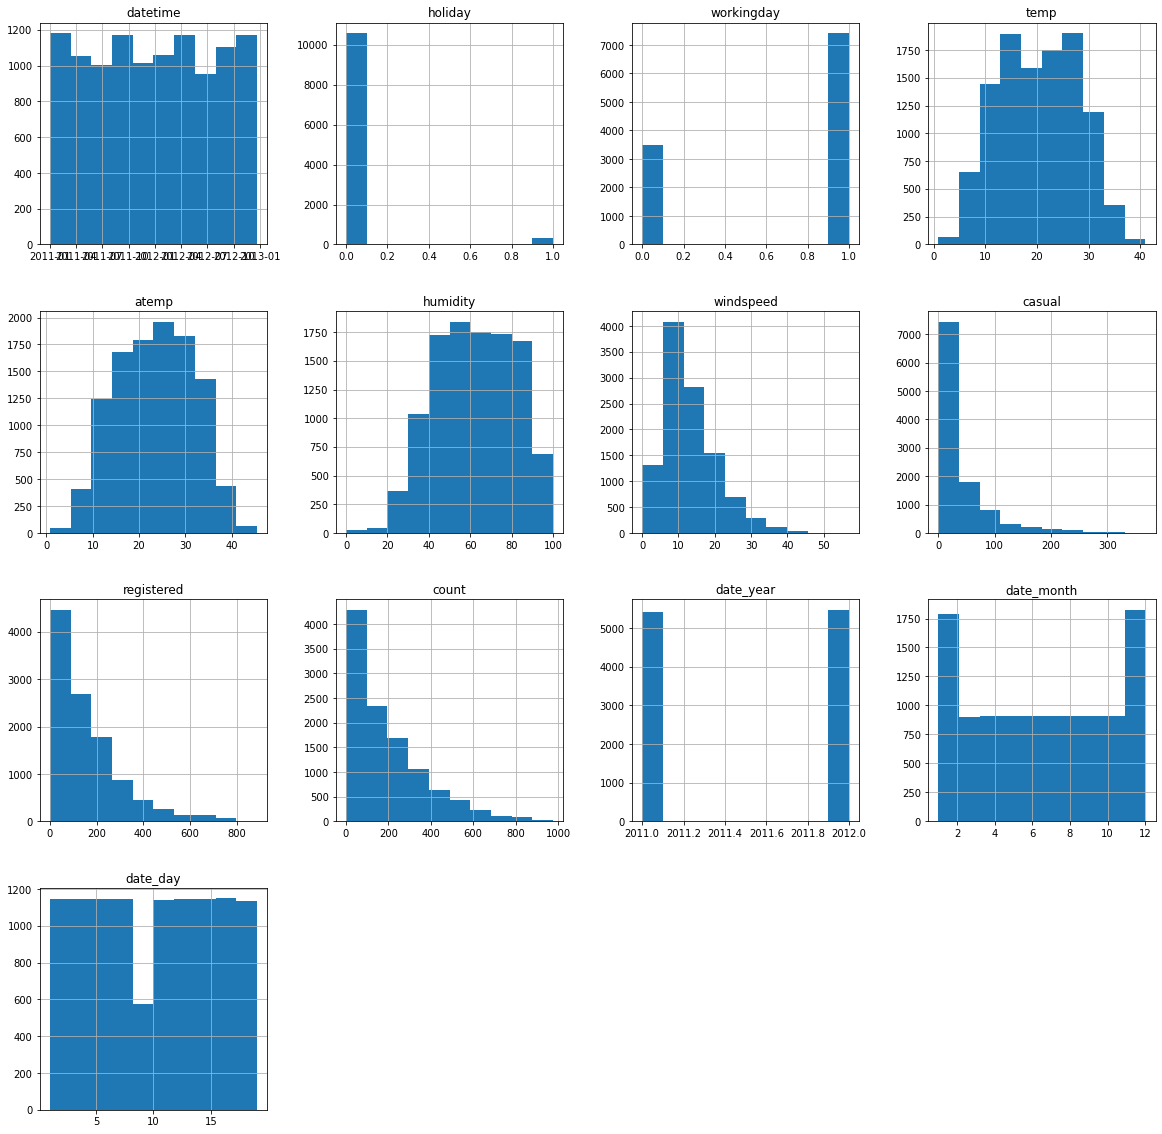

In [28]:
# View histogram of all features again now with the hour feature
train.hist(figsize =(20,20))

## Step 5: Rerun the model with the same settings as before, just with more features

In [29]:
predictor_new_features = TabularPredictor(label = 'count', problem_type = 'regression', eval_metric = 'root_mean_squared_error').fit(train_data=df_train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221216_174407/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221216_174407/"
AutoGluon Version:  0.6.1
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2239.15 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

In [30]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.191587      15.289957  562.928780                0.001286           0.389093            3       True         14
1   RandomForestMSE_BAG_L2  -53.532091      11.111397  418.846997                0.605262          26.853703            2       True         12
2          LightGBM_BAG_L2  -55.128827      10.797282  417.939543                0.291148          25.946249            2       True         11
3          CatBoost_BAG_L2  -55.679818      10.557969  449.295194                0.051835          57.301900            2       True         13
4        LightGBMXT_BAG_L2  -60.121542      14.340426  452.437834                3.834292          60.444541            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.103712    0.030096         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54

In [31]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    23.192482
1    42.462082
2    46.269211
3    49.417591
4    51.756012
Name: count, dtype: float32

In [32]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv')
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [33]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 317kB/s]
Successfully submitted to Bike Sharing Demand

In [34]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2022-12-16 17:54:52  new features                       complete  1.79349      1.79349       
submission.csv               2022-12-16 17:43:33  first raw submission               complete  1.79476      1.79476       
submission_new_hpo.csv       2022-12-16 16:21:20  new features with hyperparameters  error                                
submission_new_features.csv  2022-12-16 16:18:46  new features                       complete  1.78581      1.78581       


# New Score of `1.79349`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [35]:
# !pip install sagemaker ipywidgets --upgrade --quiet

In [36]:
# time_limit = 300
# num_trials = 5
# search_strategy = 'auto'
# scheduler = 'local'

# hyperparameter_tune_kwargs = {
#     'time_limit' : time_limit,
#     'num_trials' : num_trials,
#     'searcher' : search_strategy,
#     'scheduler' : scheduler,
# }

In [40]:
predictor_new_hpo = TabularPredictor(label = 'count', problem_type = 'regression', eval_metric = 'root_mean_squared_error').fit(train_data=df_train, time_limit=1200, presets="best_quality",
                                    hyperparameters = 'default', hyperparameter_tune_kwargs='auto')

No model was trained during hyperparameter tuning NeuralNetTorch_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 77.37s of the 334.14s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-54.9122	 = Validation score   (-root_mean_squared_error)
	39.82s	 = Training   runtime
	0.25s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 290.35s of remaining time.
	-52.7762	 = Validation score   (-root_mean_squared_error)
	0.51s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 910.36s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20221216_180342/")


In [41]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.776245       0.998645  434.318009                0.001289           0.514155            3       True         19
1   RandomForestMSE_BAG_L2  -53.373639       0.749981  311.919231                0.000176          32.524924            2       True         14
2     ExtraTreesMSE_BAG_L2  -53.861193       0.749972  291.048616                0.000168          11.654308            2       True         16
3        XGBoost_BAG_L2/T1  -54.837842       0.749905  319.908369                0.000100          40.514061            2       True         17
4     LightGBMLarge_BAG_L2  -54.912201       0.996820  319.215156                0.247016          39.820848            2       True         18
5       LightGBM_BAG_L2/T1  -55.101083       0.749895  309.289712         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1/T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2/T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L2/T1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEn

In [42]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    23.529358
1    41.016785
2    45.775219
3    48.233826
4    51.565849
Name: count, dtype: float32

In [43]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv')
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [44]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 348kB/s]
Successfully submitted to Bike Sharing Demand

In [45]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-12-16 18:19:28  new features with hyperparameters  complete  1.80664      1.80664       
submission_new_features.csv  2022-12-16 17:54:52  new features                       complete  1.79349      1.79349       
submission.csv               2022-12-16 17:43:33  first raw submission               complete  1.79476      1.79476       
submission_new_hpo.csv       2022-12-16 16:21:20  new features with hyperparameters  error                                


#### New Score of `1.80664`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

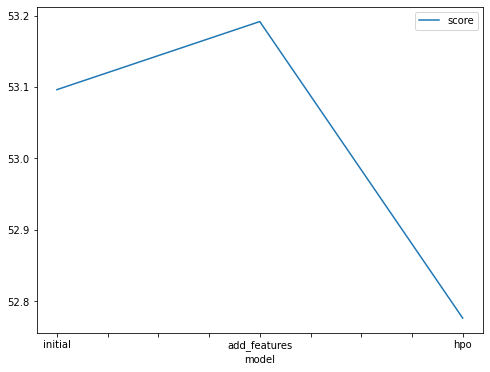

In [46]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [53.096195, 53.191587, 52.776245]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

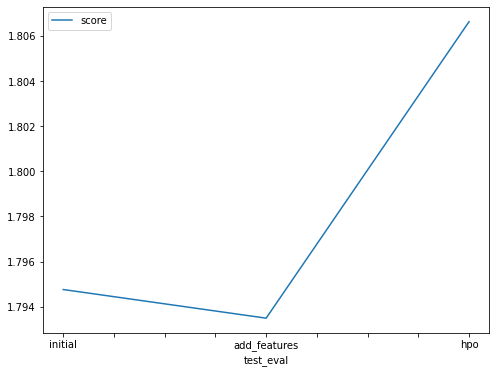

In [47]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.79476, 1.79349, 1.80664]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [48]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['time_limit = 600', 'presets=best_quality', 'hyperparameters = default'],
    "hpo2": ['time_limit = 600', 'presets=best_quality', 'hyperparameters = default'],
    "hpo3": ['time_limit = 1200', 'presets=best_quality', 'hyperparameters = auto'],
    "score": [1.79476, 1.79349, 1.80664]
})

model                       hpo1                       hpo2  \
0       initial           time_limit = 600           time_limit = 600   
1  add_features       presets=best_quality       presets=best_quality   
2           hpo  hyperparameters = default  hyperparameters = default   

                     hpo3    score  
0       time_limit = 1200  1.79476  
1    presets=best_quality  1.79349  
2  hyperparameters = auto  1.80664